*Explainability AI (A5) - Michele Pulvirenti*

# TD2 - Logistic Regression and trees

We will use data from a cardiology study to try to assess the impact of cholesterol on theprobability of having a heart attack.

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from itertools import product
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, log_loss

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Question 1

### Import data and describe the features

In [2]:
heart_disease = fetch_ucirepo(id=45) 
  
X = heart_disease.data.features 
y = heart_disease.data.targets 

data = heart_disease.data.original
  
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


### Make an educated guess on the effect that you expect that variable to have

- **age:** the risk should increase with age
- **sex:** men are generally at higher risk of heart disease compared to women
- **cp (chest pain):** different types of chest pain can indicate varying risks for heart disease
- **trestbps (resting blood pressure):** high resting blood pressure (hypertension) is a key risk factor for cardiovascular diseases
- **chol (serum cholesterol):** high cholesterol levels can increase the risk of heart disease
- **fbs (fasting blood sugar > 120 mg/dl):** elevated fasting blood sugar levels (diabetes) are strongly associated with increased cardiovascular risk
- **thalach (maximum heart rate achieved):** lower maximum heart rate during exercise stress tests may indicate cardiovascular problems
- **exang (exercise-induced angina):** angina induced by exercise is a symptom that suggests the heart is not getting enough oxygen and can lead to heart disease
- **oldpeak (ST depression induced by exercise):** ST depression during an exercise is a sign of poor blood flow to the heart
- **slope (slope of the peak exercise ST segment):** certain patterns in the slope of the ST segment can indicate different risks for heart disease
- **ca (number of major vessels colored by fluoroscopy):** the number of major coronary arteries affected by atherosclerosis is directly linked to the severity of coronary artery disease
- **thal (Thalassemia test result):** thallium stress tests or similar can help detect the presence of coronary artery disease or other heart-related conditions

### Check with a quick statistic if the guess was correct

In [3]:
data.corr(method='pearson', numeric_only=True)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.362605,0.127389,0.222853
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.093185,0.380936,0.224469
cp,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.233214,0.265246,0.407075
trestbps,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098773,0.133554,0.157754
chol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.119000,0.014214,0.070909
fbs,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.145478,0.071358,0.059186
restecg,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.128343,0.024531,0.183696
thalach,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.264246,-0.279631,-0.415040
exang,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.145570,0.329680,0.397057
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.295832,0.341004,0.504092


Positive Correlations:

- **ca (number of major vessels colored by fluoroscopy)**: Correlation of **0.519** with *num*. This shows a strong positive relationship, so more colored vessels are associated with a higher risk.
- **thal (thalassemia):** Correlation of **0.510** with *num*. This also shows a strong positive relationship, indicating that certain thalassemia conditions may correlate with heart disease risk.
- **oldpeak:** Correlation of **0.504** with *num*. This suggests that higher ST depression induced by exercise is associated with an increased risk of heart disease.
- **cp (chest pain type):** Correlation of **0.407** with *num*.This indicates a moderate positive relationship, so higher values of *cp* are associated with a higher risk of heart disease.
- **exang (exercise induced angina):** Correlation of **0.397** with *num*. This suggests that the presence of exercise-induced angina is linked to a higher risk of heart disease.
- **slope (slope of the peak exercise ST segment):** Correlation of **0.378** with *num*. This indicates a moderate positive relationship, suggesting that a more favorable slope is associated with a higher risk of heart disease.
- **sex:** Correlation of **0.224** with *num*. This indicates a weak positive relationship, suggesting that gender may have a slight influence on the risk of heart disease.
- **age:** Correlation of **0.223** with *num*. While this is lower than the others, it still indicates that older age is associated with higher heart disease risk.
- **restecg (resting electrocardiographic results):** Correlation of **0.184** with *num*. This shows a weak positive relationship, implying that certain electrocardiographic results may slightly correlate with increased heart disease risk.
- **trestbps (resting blood pressure):** Correlation of **0.158** with *num*. This indicates a weak positive relationship, suggesting that higher resting blood pressure may be associated with a slightly increased risk of heart disease.
- **chol (serum cholesterol):** Correlation of **0.071** with *num*. This shows a very weak positive relationship, indicating that higher serum cholesterol levels have a negligible impact on the risk of heart disease.
- **fbs (fasting blood sugar > 120 mg/dl):** Correlation of **0.059** with *num*. This indicates a negligible positive relationship, suggesting that fasting blood sugar levels have a minimal effect on heart disease risk.

Negative Correlation:

- **thalach (maximum heart rate achieved):** Correlation of **-0.415** with *num*. This indicates that a higher maximum heart rate achieved is associated with a lower risk of heart disease.


Surprisingly for me, **age** and **sex** are weakly correlated to the risk of heart disease and **chol** and **fbs** are not so relevant features.

### Clean the variables removing or imputing NAs

Let's check for data info

In [4]:
info = data.describe().transpose()
info["missing_values"] = data.isnull().sum()
info

,count,mean,std,min,25%,50%,75%,max,missing_values
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0,0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0,0
cp,303.0,3.158416,0.960126,1.0,3.0,3.0,4.0,4.0,0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0,0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0,0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0,0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0,0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0,0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0,0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2,0


Since we have very few missing data, we can simply drop the rows containing missing values

In [5]:
data = data.dropna()

## Question 2

### Make a few plots to get a better understanding of the data.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>,
        <Axes: title={'center': 'num'}>, <Axes: >, <Axes: >]],
      dtype=object)

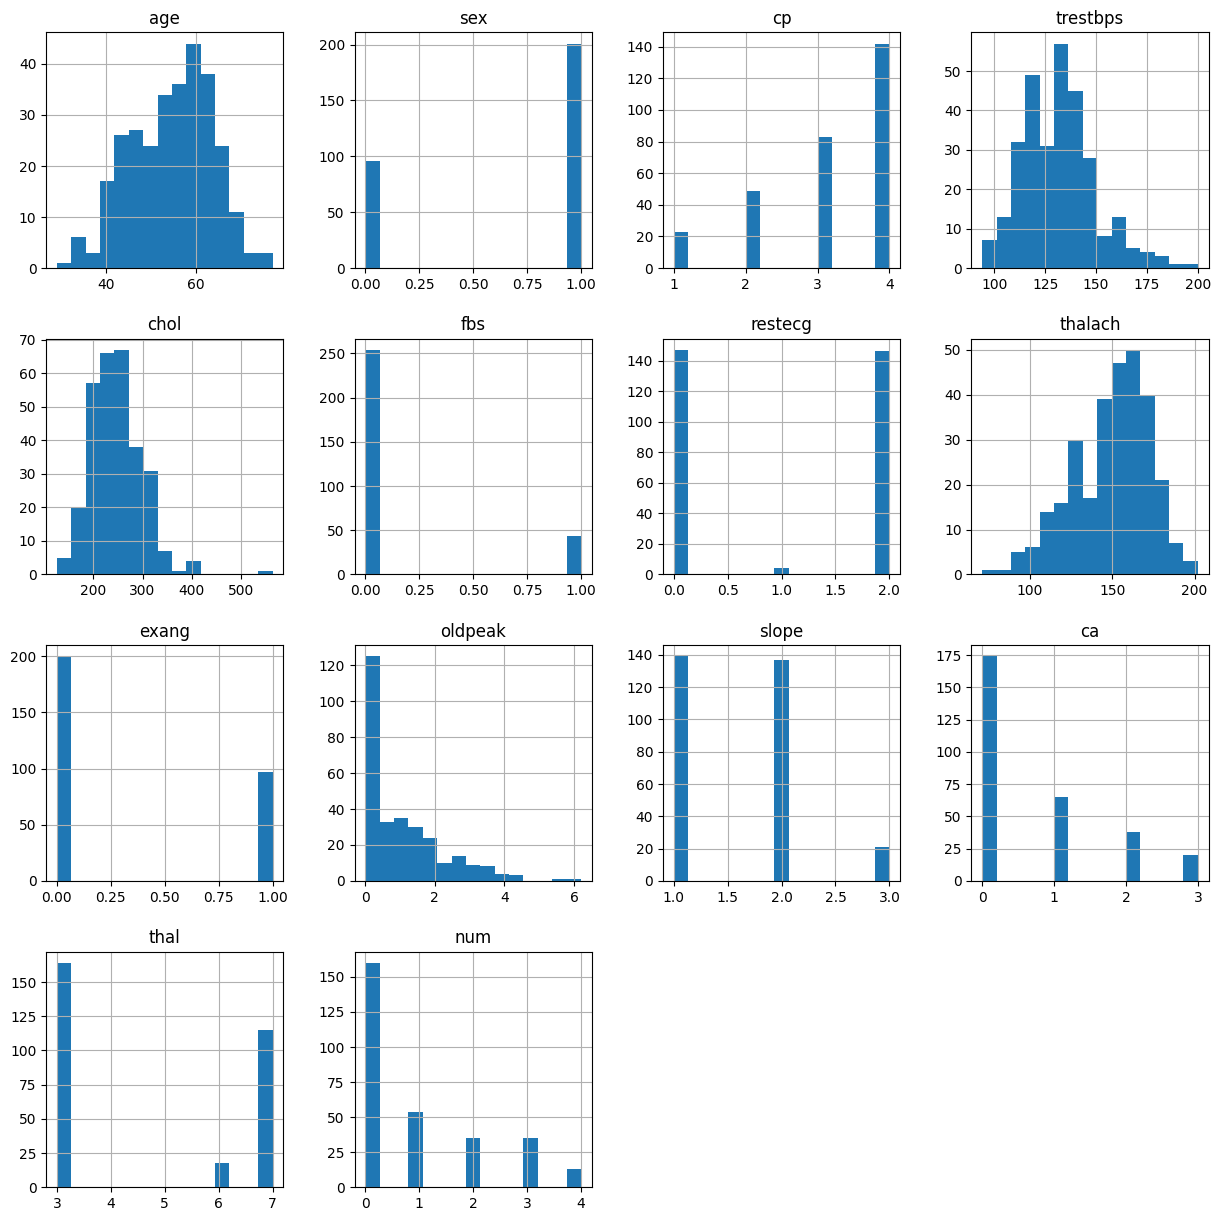

In [6]:
data.hist(bins=15, figsize=(15,15), layout=(4,4))

<Axes: title={'center': 'num'}, xlabel='ca'>

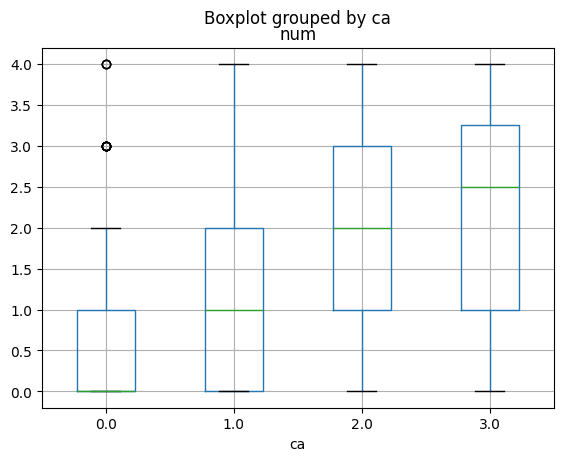

In [7]:
data.boxplot(by="ca", column="num")

<Axes: title={'center': 'num'}, xlabel='thal'>

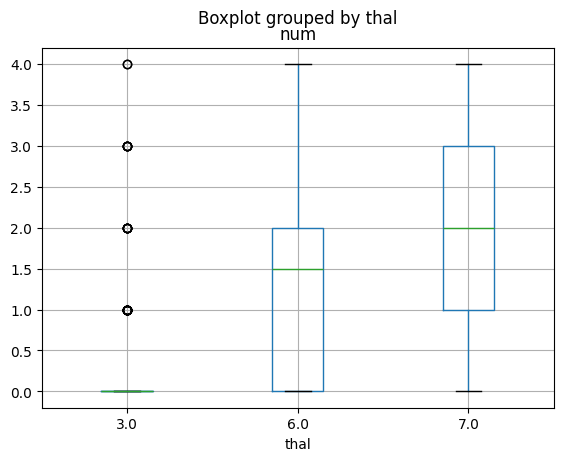

In [8]:
data.boxplot(by="thal", column="num")

<Axes: xlabel='oldpeak', ylabel='num'>

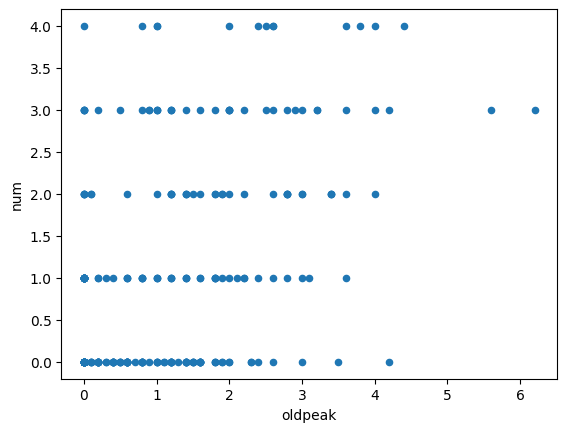

In [9]:
data.plot.scatter(x="oldpeak", y="num")

<Axes: xlabel='thalach', ylabel='num'>

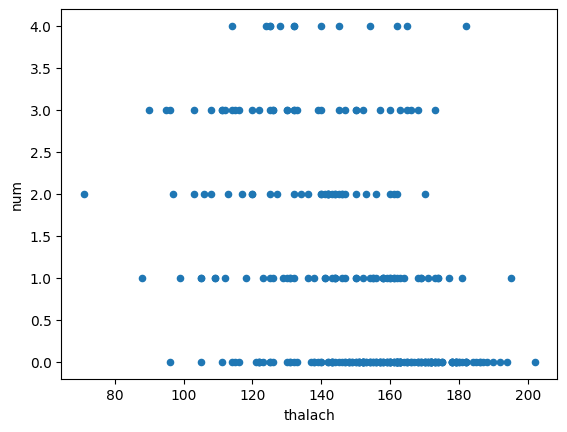

In [10]:
data.plot.scatter(x="thalach", y="num")

## Question 3

### Do a quick logistic regression with two classess
Target 0 from one side (healthy) and target 1 to 4 on the other side (sick)

- One hot encoding

In [11]:
data = pd.get_dummies(data, columns=["sex", "cp", "fbs", "restecg", "exang", "slope"], drop_first=True, dtype=int)
data["num"] = data["num"].apply(lambda x: 1 if x>0 else 0)
data

,age,trestbps,chol,thalach,oldpeak,ca,thal,num,sex_1,cp_2,cp_3,cp_4,fbs_1,restecg_1,restecg_2,exang_1,slope_2,slope_3
0,63,145,233,150,2.3,0.0,6.0,0,1,0,0,0,1,0,1,0,0,1
1,67,160,286,108,1.5,3.0,3.0,1,1,0,0,1,0,0,1,1,1,0
2,67,120,229,129,2.6,2.0,7.0,1,1,0,0,1,0,0,1,1,1,0
3,37,130,250,187,3.5,0.0,3.0,0,1,0,1,0,0,0,0,0,0,1
4,41,130,204,172,1.4,0.0,3.0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,140,241,123,0.2,0.0,7.0,1,0,0,0,1,0,0,0,1,1,0
298,45,110,264,132,1.2,0.0,7.0,1,1,0,0,0,0,0,0,0,1,0
299,68,144,193,141,3.4,2.0,7.0,1,1,0,0,1,1,0,0,0,1,0
300,57,130,131,115,1.2,1.0,7.0,1,1,0,0,1,0,0,0,1,1,0


- Use the logistic regressor to determine the probability

In [12]:
def calculate_performances(y_test, y_pred, y_pred_proba):
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  conf_matrix = confusion_matrix(y_test, y_pred)
  logloss = log_loss(y_test, y_pred_proba)
  return accuracy, roc_auc, conf_matrix, logloss

def print_performances(accuracy, roc_auc, logloss, conf_matrix=None):
  print(f"Accuracy: {accuracy:.2f}")
  print(f"ROC-AUC Score: {roc_auc:.2f}")
  print(f"Log Loss: {logloss:.2f}")
  if conf_matrix is not None:
    print(f"Confusion Matrix:\n{conf_matrix}")

In [13]:
X = data.drop("num", axis=1)
y = data["num"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=100000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

accuracy, roc_auc, conf_matrix, logloss = calculate_performances(y_test, y_pred, y_pred_proba)
print_performances(accuracy, roc_auc, logloss, conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.87
ROC-AUC Score: 0.95
Log Loss: 0.30
Confusion Matrix:
[[32  4]
 [ 4 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.83      0.83      0.83        24

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



**1. Accuracy**

The model correctly classified 87% of cases. While accuracy alone doesn’t capture all aspects of performance, a score of 0.87 indicates a generally reliable model in this context.

**2. Precision and Recall**

- *Class 0 (No Disease)*: Precision is 0.89, meaning that 89% of the cases the model predicted as "No Disease" were actually correct. Recall is also 0.89, indicating that it correctly identified 89% of the true "No Disease" cases.

- *Class 1 (Disease)*: Precision is 0.83, so 83% of the cases predicted as "Disease" were actually correct. Recall is 0.83 as well, indicating the model captured 83% of true "Disease" cases.

The balanced precision and recall suggest that the model does a good job distinguishing between the two classes without heavily favoring one over the other.

**3. F1-score**

The F1-scores are 0.89 for class 0 and 0.83 for class 1. 
Since F1-score is the harmonic mean of precision and recall, these values indicate a balanced performance across both classes, which is especially useful when the consequences of false positives and false negatives are significant.

**4. ROC-AUC Score**

The ROC-AUC score is 0.95, which is excellent and indicates that the model has a high ability to distinguish between the two classes. This score reflects that the model performs well across different decision thresholds, and it’s highly effective at ranking patients by their probability of having heart disease.

**5. Confusion Matrix**

- Out of 36 true "No Disease" cases, it correctly identified 32 and misclassified 4 as "Disease" (false positives).
- Out of 24 true "Disease" cases, it correctly identified 20 and misclassified 4 as "No Disease" (false negatives).

The misclassification rate is relatively low, and the even distribution of errors between false positives and false negatives suggests balanced performance across classes.

**5. Log Loss**

The log loss is 0.30, which indicates how closely the predicted probabilities align with the true labels. Lower log loss values indicate that the model’s probability estimates are accurate. A log loss of 0.30 is relatively low, suggesting good calibration in its probability estimates.

In [14]:
print("Intercept:", logreg.intercept_)
coefficients = logreg.coef_
coeff = {}
for index, column in enumerate(X.columns):
  coeff[column] = coefficients[0][index]
print("\nCoefficients:", coeff )

Intercept: [-5.40697917]

Coefficients: {'age': -0.012097734397372634, 'trestbps': 0.024373262398087438, 'chol': 0.005270298004657061, 'thalach': -0.01904047023372454, 'oldpeak': 0.38377359835594643, 'ca': 1.1461013887170766, 'thal': 0.2925763224056458, 'sex_1': 1.1420056224833193, 'cp_2': 0.5591713583383163, 'cp_3': -0.4135503997328668, 'cp_4': 0.9717802696259141, 'fbs_1': -0.7607664112749941, 'restecg_1': 0.038348108990924036, 'restecg_2': 0.3394626596126102, 'exang_1': 0.6859043985972378, 'slope_2': 0.5732826917854633, 'slope_3': 0.1468503312518598}


**1. Intercepts**

- The intercept is −5.41, representing the log-odds of heart disease being absent when all other feature values are zero.
- In this model, a negative intercept suggests that, with baseline values, the model leans toward predicting the absence of heart disease (class 0).

**2. Coefficients**

- Each coefficient represents the change in the log odds of having heart disease associated with a one-unit increase in that feature, assuming all other features are held constant.
- Positive coefficients indicate that an increase in that feature is associated with higher odds of heart disease, while negative coefficients imply that an increase is associated with lower odds.

**3. Interpretation**

The most influential variables are *ca*, *oldpeak*, *sex_1*, *cp_4*, and *exang_1*. These features significantly increase the odds of heart disease, which aligns with known risk factors. 

*Cholesterol* has a small effect in this model, which differs from its known risk factor status; this might be due to the interaction effects or distribution of other features in the dataset.

Overall, the model parameters align reasonably well with expectations from medical knowledge, validating the model’s approach to predicting heart disease likelihood.

**4. Differences with previous metrics**

- Prediction & Evaluation Metrics: These metrics evaluate how well the logistic regression model is making predictions and its performance on the test set. They assess aspects such as:
  - Overall prediction accuracy (accuracy_score).
  - Discriminatory power of the model (roc_auc_score).
  - Error rates (log_loss and confusion matrix).
- Intercept & Coefficients: These are not evaluation metrics but rather provide interpretability for the model. They tell you how the model is making its decisions:
  - Intercept: The starting point of the log-odds of the outcome.
  - Coefficients: The effect of each feature on the log-odds. These help in understanding which features have the most significant impact on predicting the outcome.

**5. Conclusion on the Most Important Variables:**

The most important variables based on their coefficients in this logistic regression model are:

- *ca* (Number of Major Vessels Colored by Fluoroscopy): Coefficient of 1.146
- *oldpeak* (ST Depression Induced by Exercise): Coefficient of 0.384
- *sex_1* (Male): Coefficient of 1.142
- *cp_4* (Chest Pain): Coefficient of 0.972
- *exang_1* (Exercise-Induced Angina): Coefficient of 0.686
- *slope_2* (Flat Slope of Peak Exercise ST Segment): Coefficient of 0.573

These features have the highest positive coefficients, indicating that they have the strongest impact on increasing the odds of heart disease in the model.
These results are quite intuitive based on medical knowledge about heart disease risk factors.

**6. Analysis of Cholesterol feature**

The cholesterol (*chol*) coefficient is quite small, at 0.005, suggesting that in this model, it does not contribute much to predicting heart disease. 
This result can be surprising because high cholesterol is generally understood as a risk factor.

 However, there are a few reasons why this might be the case:

- Feature Interactions: Cholesterol levels might interact with other features (like age, sex, or exercise-induced angina), leading to reduced independent predictive power in the model.
- Dataset Distribution: If the range or variance of cholesterol values in this dataset is limited or if many patients have similar cholesterol levels, it might not distinguish well between those with and without heart disease.
- Nonlinear Relationships: Logistic regression assumes linear relationships, and the effect of cholesterol on heart disease might be nonlinear or may become more significant in interaction with other risk factors, which a simple logistic model might not capture.

**7. Comparison to Previous Statistics**

In the previous logistic regression model, the coefficient of cholesterol was also small, indicating a consistent finding. The ROC-AUC score and log-loss measures indicated that the model performs well overall, despite cholesterol's limited impact as a feature.

## Question 4

### Use a different model: decision tree

A decision tree works by recursively partitioning the data into smaller subsets based on feature values, in order to minimize impurity (classification) or variance (regression). It continues until certain stopping criteria are met, leading to the formation of leaf nodes that provide the final prediction.

In [15]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)
y_pred_proba = dtree.predict_proba(X_test)[:, 1]

accuracy, roc_auc, conf_matrix, logloss = calculate_performances(y_test, y_pred, y_pred_proba)

print_performances(accuracy, roc_auc, logloss, conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.80
ROC-AUC Score: 0.81
Log Loss: 7.21
Confusion Matrix:
[[28  8]
 [ 4 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60



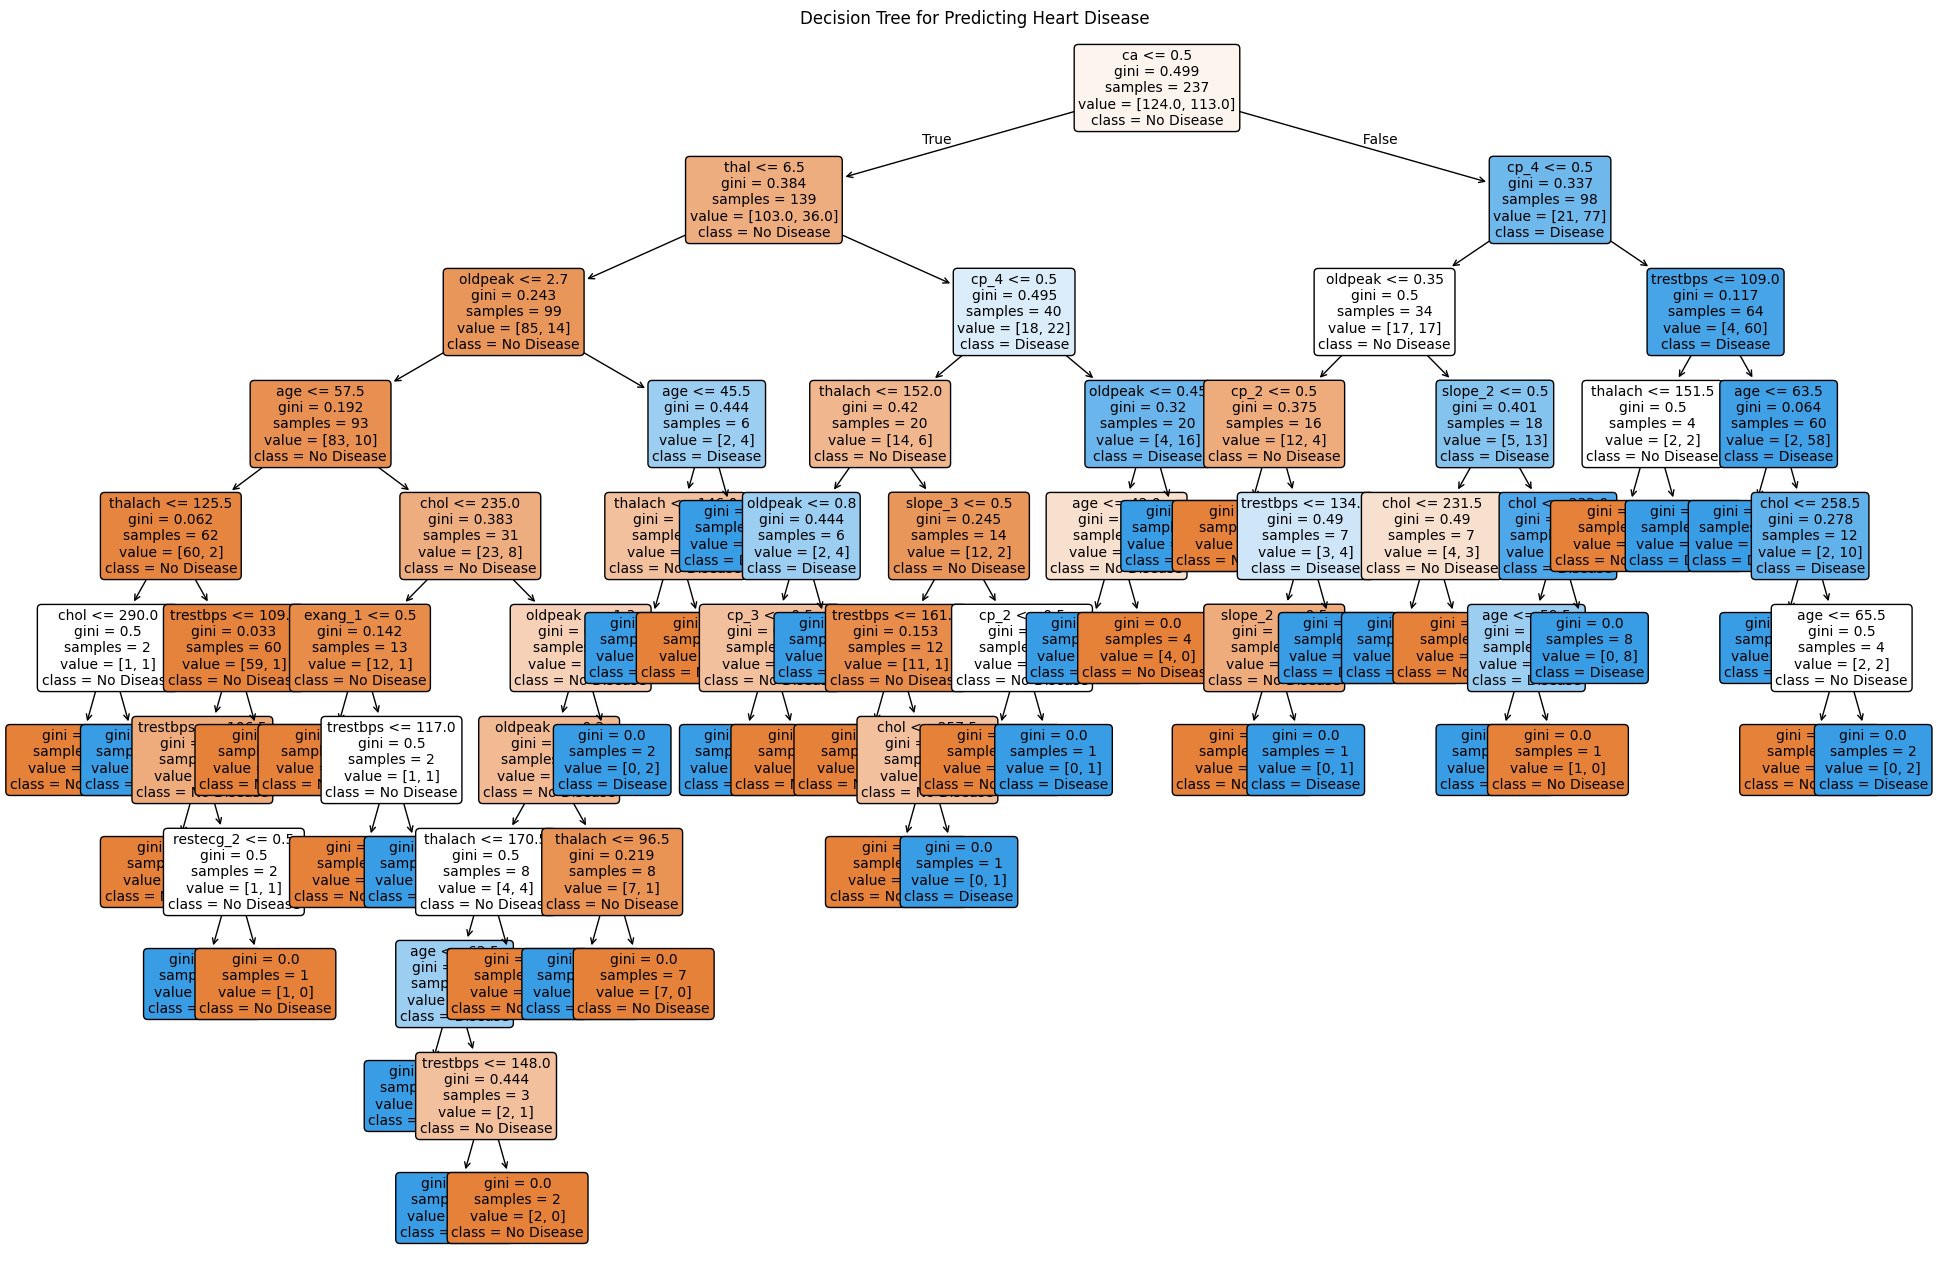

In [16]:
plt.figure(figsize=(24, 16))
plot_tree(dtree, filled=True, feature_names=X.columns, class_names=["No Disease", "Disease"], rounded=True, fontsize=10)
plt.title("Decision Tree for Predicting Heart Disease")
plt.show()

The decision tree works as espected, but there is a surprising thing.

It uses in upper levels of the tree *thal* and *trestbps* that have low coefficient in the previous analysis.

- Now, let's search the best hyperparameters for Decision Tree

Accuracy: 0.92
ROC-AUC Score: 0.95
Log Loss: 0.28
Best Parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 9}


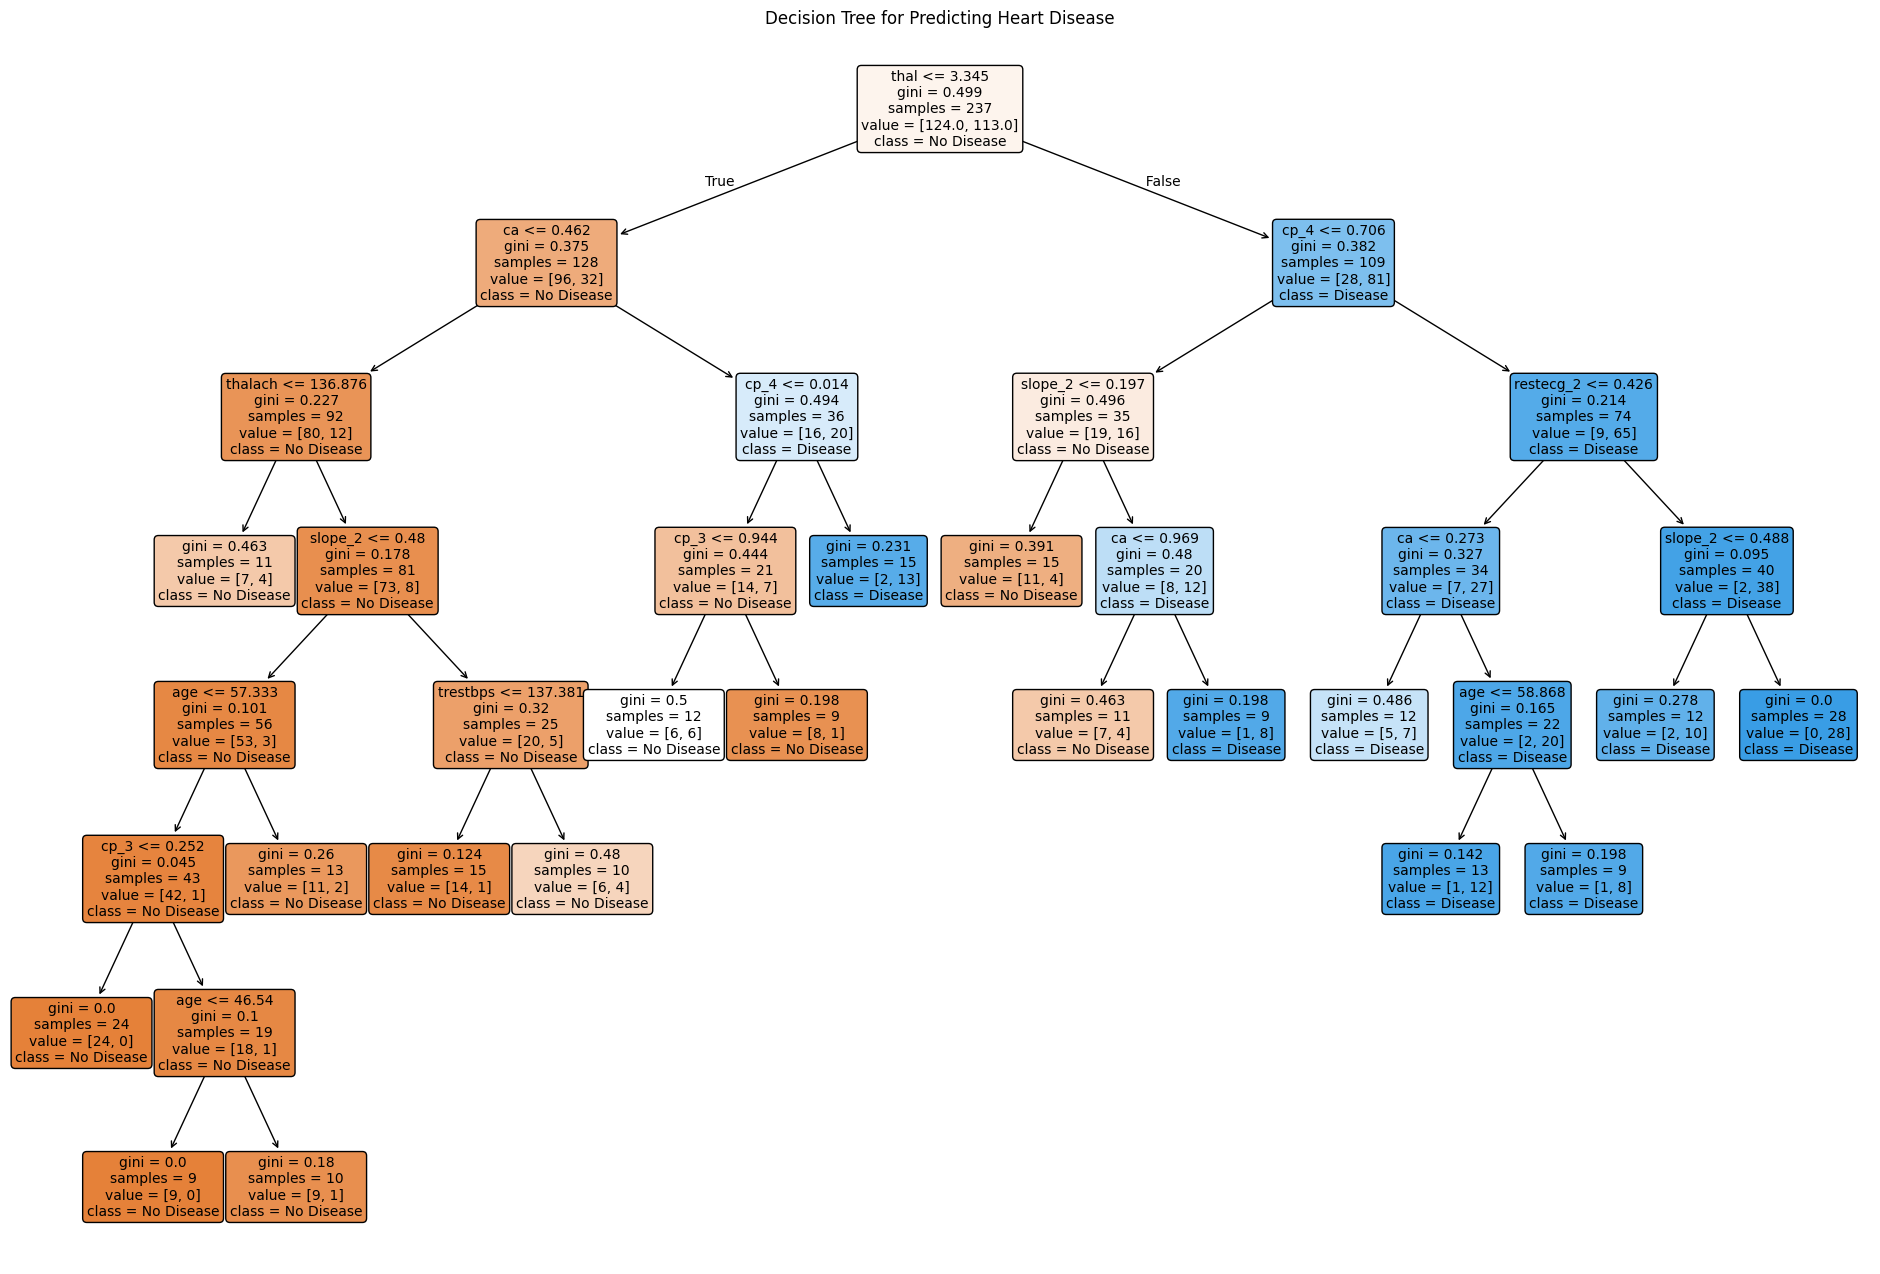

In [17]:
X = data.drop("num", axis=1)
y = data["num"]

best_accuracy = 0
best_loss = 100
best_roc_auc = 0

criterion_options = ["gini", "entropy"]
splitter_options = ["best", "random"]
max_depth_options = [None] + list(range(1, 11))
min_samples_split_options = list(range(2, 11))
min_samples_leaf_options = list(range(2, 11))
best_params = {}

combinations = product(
    criterion_options,
    splitter_options,
    max_depth_options,
    min_samples_split_options,
    min_samples_leaf_options
)

for criterion, splitter, max_depth, min_samples_split, min_samples_leaf in list(combinations):
  
  dtree = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
  dtree.fit(X_train, y_train)

  y_pred = dtree.predict(X_test)
  y_pred_proba = dtree.predict_proba(X_test)[:, 1]

  accuracy, roc_auc, conf_matrix, logloss = calculate_performances(y_test, y_pred, y_pred_proba)

  if accuracy > best_accuracy and logloss < best_loss and roc_auc > best_roc_auc:
    best_dtree = dtree
    best_accuracy = accuracy
    best_loss = logloss
    best_roc_auc = roc_auc
    best_params = {
            "criterion": criterion,
            "splitter": splitter,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf
        }

print_performances(best_accuracy, best_roc_auc, best_loss)
print("Best Parameters:", best_params)

plt.figure(figsize=(24, 16))
plot_tree(best_dtree, filled=True, feature_names=X.columns, class_names=["No Disease", "Disease"], rounded=True, fontsize=10)
plt.title("Decision Tree for Predicting Heart Disease")
plt.show()

**Results**

- Logistic Regression:

  Accuracy: 0.87
  ROC-AUC Score: 0.95
  Log Loss: 0.30

- Decision Tree (with best hyperparameters):

  Accuracy: 0.92
  ROC-AUC Score: 0.95
  Log Loss: 0.28

Overall, the two models perform in a similar way but the Decision Tree, with best hyperparameters, has a higher accuracy and a smaller log loss.

So the Decision Tree with 
- 'criterion': 'gini'
- 'splitter': 'random'
- 'max_depth': None
- 'min_samples_split': 2
- 'min_samples_leaf': 9

gives the best results

**Weights in a decision tree**

In a decision tree, weights (or feature importance) are computed based on how much each feature improves the purity of the data at each split. 

Specifically, the algorithm calculates the Gini impurity or entropy before and after each split. The feature that results in the largest reduction in impurity is considered the most important. 

This process is repeated recursively at each node, with the importance of a feature being proportional to the reduction in impurity it causes across the tree.

## Question 5.

### We are going to use a random forest algorithm now

In [18]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': list(range(2,11,2)),
    'min_samples_leaf': list(range(1,4)),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy, roc_auc, conf_matrix, logloss = calculate_performances(y_test, y_pred, y_pred_proba)
print_performances(accuracy, roc_auc, logloss, conf_matrix=conf_matrix)


Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
Accuracy: 0.85
ROC-AUC Score: 0.94
Log Loss: 0.33
Confusion Matrix:
[[31  5]
 [ 4 20]]


**Results**

- Logistic Regression:

  Accuracy: 0.87
  ROC-AUC Score: 0.95
  Log Loss: 0.30

- Decision Tree (with best hyperparameters):

  Accuracy: 0.92
  ROC-AUC Score: 0.95
  Log Loss: 0.28

- Random Forest (with best hyperparameters):

  Accuracy: 0.85
  ROC-AUC Score: 0.94
  Log Loss: 0.33

The decision tree is still the best performing model


- Check for most important variables

In [19]:
importance = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

      Feature  Importance
5          ca    0.240901
6        thal    0.153180
4     oldpeak    0.118352
10       cp_4    0.109823
3     thalach    0.091275
2        chol    0.064165
0         age    0.063781
1    trestbps    0.049112
14    exang_1    0.034697
7       sex_1    0.022927
9        cp_3    0.021242
13  restecg_2    0.011121
15    slope_2    0.010492
11      fbs_1    0.004251
8        cp_2    0.003943
16    slope_3    0.000738
12  restecg_1    0.000000
